In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
import regex as re
import json
import os
import math
import random
from datetime import datetime, timedelta
historical_data_url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
MAP_KEY = "85ad147fd1890d06e0e2db5bb9d95b57"
da_url = 'https://firms.modaps.eosdis.nasa.gov/api/country/csv/' + MAP_KEY + '/MODIS_NRT/USA/10/2025-1-19'

In [242]:
def get_data():
  # generate random year month date between the function of MODIS_SP satellite
  rand_year = random.randint(2017, 2023)
  rand_month = random.randint(1, 12)
  rand_day = random.randint(1, 30)
  #get fire data
  nasa_url = 'https://firms.modaps.eosdis.nasa.gov/api/country/csv/' + MAP_KEY + '/MODIS_SP/USA/1/' + str(rand_year) + '-' + str(rand_month) + '-' + str(rand_day)
  df = pd.read_csv(nasa_url)
  df['latitude'] = np.round(df['latitude'], 2)
  df['longitude']  = np.round(df['longitude'], 2)
  df = (
      df[df['confidence'] >= 80]
      .set_index(['latitude', 'longitude'])
      .index.unique()
      )
  fire_lat = [i[0] for i in df]
  fire_long = [i[1] for i in df]
  #get weather data
  weather_data = clean_weather(historical_data_url, param_generator(fire_lat, fire_long, rand_year, rand_month, rand_day))
  weather_data['fire'] = 1
  #write to json
  to_fire_data(weather_data)
  return weather_data

In [243]:
#@title to JSON func
def to_fire_data(df):

  json_data = df.to_dict(orient='records')

  if os.path.exists("./fire_data.json") and os.path.getsize("./fire_data.json") > 0:
    with open("./fire_data.json", "r") as f:
      try:
        existing_data = json.load(f)
      except json.JSONDecodeError:
        existing_data = []
  else:
    existing_data = []

  existing_data.extend(json_data)

  with open("./fire_data.json", "w") as f:
    json.dump(existing_data, f)

  return

In [244]:
def param_generator(lat, long, year, month, day):
    base_date = datetime(year, month, day)

    end_date = base_date - timedelta(days=10)

    start_date = base_date - timedelta(days=50)

    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')

    return {
        "latitude": lat,
        "longitude": long,
        "daily": ["temperature_2m_max", "temperature_2m_min",
                  "precipitation_sum", "rain_sum", "showers_sum",
                  "snowfall_sum", "wind_speed_10m_max", "wind_gusts_10m_max",
                  "et0_fao_evapotranspiration"],
        "start_date": start_date_str,
        "end_date": end_date_str
    }

In [250]:
def clean_weather(url, params):
  data = requests.get(url, params);
  clean = re.split(r'(?<=\}),(?=\{)', data.text)
  cleaned_df = pd.DataFrame()
  for coordinate_json in clean:
      extract_cords = re.search(r'{"latitude":[\d\.-]+,"longitude":[\d\.-]+,',
                                coordinate_json)
      extract_output = re.search(r'"daily":{(.*})}', coordinate_json)
      cleaned_df = pd.concat([cleaned_df, pd.read_json(
          StringIO(extract_cords.group() + extract_output.group(1))
          )
      ])
  divide_time = cleaned_df['time'].str.split(r'\-')
  cleaned_df['year'] = divide_time.str[0]
  cleaned_df['month'] = divide_time.str[1]
  cleaned_df['day'] = divide_time.str[2]
  cleaned_df.drop(columns=['time'], inplace=True)
  new_column_order = ['latitude', 'longitude', 'year', 'month', 'day',
                      'temperature_2m_max', 'temperature_2m_min',
                      'precipitation_sum', 'rain_sum', 'showers_sum',
                      'snowfall_sum', 'wind_speed_10m_max', 'wind_gusts_10m_max',
                      'et0_fao_evapotranspiration']
  return cleaned_df[new_column_order]

# WILDFIRE-API

In [246]:
len(pd.read_json('./fire_data.json'))

702

In [251]:
get_data()

,latitude,longitude,year,month,day,temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,showers_sum,snowfall_sum,wind_speed_10m_max,wind_gusts_10m_max,et0_fao_evapotranspiration,fire
0,31.736244,-101.79265,2019,08,02,37.3,24.6,0.0,0.0,0,0.0,27.0,42.5,9.26,1
1,31.736244,-101.79265,2019,08,03,38.5,25.0,0.0,0.0,0,0.0,20.5,42.8,9.07,1
2,31.736244,-101.79265,2019,08,04,36.9,24.6,0.0,0.0,0,0.0,20.2,36.7,8.56,1
3,31.736244,-101.79265,2019,08,05,35.8,23.2,0.0,0.0,0,0.0,15.2,31.0,7.59,1
4,31.736244,-101.79265,2019,08,06,37.7,25.6,0.0,0.0,0,0.0,21.1,36.0,7.93,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,46.887886,-120.90687,2019,09,07,23.8,12.0,0.0,0.0,0,0.0,15.6,22.3,3.91,1
37,46.887886,-120.90687,2019,09,08,23.1,11.1,4.5,4.5,0,0.0,25.4,46.1,3.51,1
38,46.887886,-120.90687,2019,09,09,16.4,8.8,1.8,1.8,0,0.0,22.7,38.9,2.59,1
39,46.887886,-120.90687,2019,09,10,15.1,7.6,7.6,7.6,0,0.0,12.5,29.2,1.75,1


# WEATHER-API

---------------------------------------------------

**WEATHER API ROUNDS TO TWO DECIMAL PLACES DESPITE HAVING PRECISION BEYOND THAT**

--------------------------------------------------------------------------------

# **Model Training**

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV



***WHATS NEXT***
*   Figure out design matrix, EDA
*   Get more data for fire and nonfire cords
* Train model
* What is training acc?
* Test model on unseen data
* What is test acc?
* AUC curve and fine tune




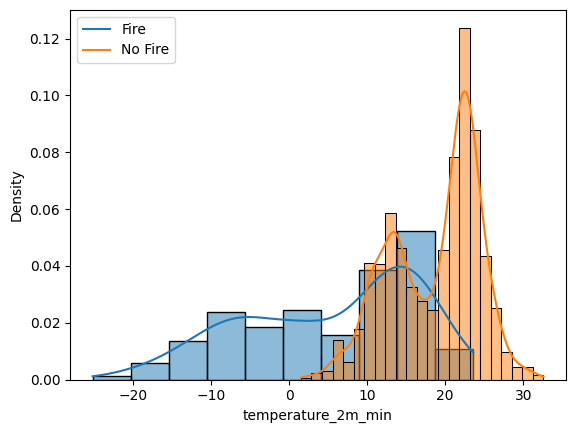

In [252]:
updated_df = pd.read_json('./fire_data.json')
sns.histplot(data=updated_df[updated_df['fire'] == 0], x='temperature_2m_min', stat = 'density', kde=True)
sns.histplot(data=updated_df[updated_df['fire'] == 1], x='temperature_2m_min', stat = 'density', kde=True)
plt.legend(['Fire', 'No Fire'])

In [253]:
pd.read_json('./fire_data.json')

,latitude,longitude,year,month,day,temperature_2m_max,temperature_2m_min,precipitation_sum,rain_sum,showers_sum,snowfall_sum,wind_speed_10m_max,wind_gusts_10m_max,et0_fao_evapotranspiration,fire
0,33.388725,-103.755066,2025,1,12,7.3,-3.0,0.0,0.0,0,0.0,24.8,37.4,1.76,0
1,33.388725,-103.755066,2025,1,13,6.4,-4.7,0.0,0.0,0,0.0,22.4,28.1,1.64,0
2,33.388725,-103.755066,2025,1,14,8.5,-4.5,0.0,0.0,0,0.0,14.3,29.5,1.91,0
3,33.388725,-103.755066,2025,1,15,8.5,-4.0,0.0,0.0,0,0.0,18.1,29.2,2.07,0
4,33.388725,-103.755066,2025,1,16,11.5,-2.8,0.0,0.0,0,0.0,18.0,23.0,2.80,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2788,46.887886,-120.906870,2019,9,7,23.8,12.0,0.0,0.0,0,0.0,15.6,22.3,3.91,1
2789,46.887886,-120.906870,2019,9,8,23.1,11.1,4.5,4.5,0,0.0,25.4,46.1,3.51,1
2790,46.887886,-120.906870,2019,9,9,16.4,8.8,1.8,1.8,0,0.0,22.7,38.9,2.59,1
2791,46.887886,-120.906870,2019,9,10,15.1,7.6,7.6,7.6,0,0.0,12.5,29.2,1.75,1


In [125]:
len(updated_df[updated_df['fire'] == 1])

416